In [1]:
import arviz as az
import arviz_plots as azp
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns

azp.style.use("arviz-vibrant")

/Users/curro/Documents/Dev/handbook-abc-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#  ABC Markov Chain Monte Carlo

## References

[ABC Samplers](https://doi.org/10.48550/arXiv.1802.09650)

## Algorithm

**Inputs:**
- Prior distribution distribution $\pi(\theta)$
- Procedure for generating data under the model $p(y|\theta)$
- Proposal symmetric density $g(\theta, \theta') = g(\theta'|\theta)$
- Number of samples $N > 0$
- Kernel function $K_h(u)$ with bandwidth $h > 0$
- Summary statistic $s = S(y)$
- Observed summary statistic $s_{obs} = S(y_{obs})$

**Algorithm:**

Initialise:
Repeat:
1. Choose an initial parameter vector $\theta^{(0)}$
2. Generate $y^(0) \sim p(y|\theta^{(0)})$ from the simulator

until $K_h(\|S(y^{(0)}) - s_{obs}\|) > 0$

Sampling

For $i = 1, \ldots, N$:
1. Generate candiate vector $\theta^{(i)} \sim g(\theta^(i-1))$ from the proposal density
2. Generate $y' \sim p(y|\theta^{(i)})$ from the simulator
3. Compute summary statistic $s' = S(y')$
4. With probability

   $w = \min \left\{1, \frac{K_h(\|s' - s_{obs}\|)\pi(\theta')}{K_h(\|s^{i-1} - s_{obs}\|)\pi(\theta^{(i-1)})}\right\}$

set $\theta^{(i)} = \theta'$ and $s^{(i)} = s'$, otherwise set $\theta^{(i)} = \theta^{(i-1)}$ and $s^{(i)} = s^{(i-1)}$.

**Output:**
- A set of correlated parameter vectors $\{\theta^{(i)}\}_{i=1}^N$ from a Markov Chain with stationary distribution approximating the posterior $\pi(\theta|s_{obs})$.

In [2]:
def gaussian_kernel(u):
    """Gaussian kernel: 1/√(2π) * exp(-u²/2)"""
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * u**2)

def abc_mcmc(
    key,
    log_prior_density,
    proposal_covariance,
    initial_positions,
    simulator,
    num_samples,
    s_obs,
    distance,
    summary_stat=lambda x: x,
    kernel=gaussian_kernel,
    h=1.0,
):
    """
    ABC Markov Chain Monte Carlo using blackjax's random walk Metropolis-Hastings.

    The ABC pseudo-logdensity (prior × kernel(distance)) is wrapped in a
    single `pure_callback` so that the (stochastic) simulator can use
    numpy/scipy internally while remaining compatible with JAX tracing.

    Args:
        key: JAX random key
        log_prior_density: function log π(θ) computing log prior density
        proposal_covariance: covariance matrix for the MvN proposal distribution
        initial_positions: list of initial position dicts, one per chain
        simulator: function (params) -> y (may use numpy internally)
        num_samples: number of MCMC steps per chain
        s_obs: observed summary statistics
        distance: distance function (s_sim, s_obs) -> scalar
        summary_stat: function S(y) computing summary statistics
        kernel: kernel function K(u)
        h: bandwidth parameter for kernel

    Returns:
        az.InferenceData with shape (len(initial_positions), num_samples)
    """
    num_chains = len(initial_positions)
    s_obs_vec = jnp.atleast_1d(s_obs)

    def _run_chain(args):
        init_pos, chain_key = args

        def abc_loglik(params, rng_key):
            rng_key, sim_key = jax.random.split(rng_key)
            lp = log_prior_density(params)
            sim = simulator(sim_key, params)
            s_sim = jnp.atleast_1d(summary_stat(jnp.asarray(sim)))
            d = distance(s_sim, s_obs_vec)
            k_val = kernel(d / h)
            log_k = jnp.log(k_val)
            return jnp.squeeze(lp + log_k)

        def one_step(carry, step_key):
            theta, log_prob_curr = carry
            step_key, prop_key, sim_key = jax.random.split(step_key, 3)

            theta_prop = theta + jax.random.normal(prop_key) * jnp.sqrt(
                proposal_covariance[0, 0]
            )
            log_prob_prop = abc_loglik({"theta": theta_prop}, sim_key)

            log_accept_ratio = log_prob_prop - log_prob_curr
            accept = jax.random.uniform(step_key) < jnp.exp(log_accept_ratio)

            new_theta = jnp.where(accept, theta_prop, theta)
            new_log_prob = jnp.where(accept, log_prob_prop, log_prob_curr)

            return (new_theta, new_log_prob), new_theta

        all_keys = jax.random.split(chain_key, num_samples)

        theta0 = init_pos["theta"]
        log_prob0 = abc_loglik({"theta": theta0}, all_keys[0])

        _, theta_samples = jax.lax.scan(one_step, (theta0, log_prob0), all_keys)

        return theta_samples

    chain_keys = jax.random.split(key, num_chains)

    # Stack initial positions
    stacked_init = jax.tree.map(
        lambda *arrays: jnp.stack(arrays, axis=0), *initial_positions
    )

    # Run chains sequentially
    all_theta_samples = []
    for i in range(num_chains):
        init_pos = {k: v[i] for k, v in stacked_init.items()}
        theta_samples = _run_chain((init_pos, chain_keys[i]))
        all_theta_samples.append(theta_samples)

    all_theta = jnp.stack(all_theta_samples, axis=0)

    posterior_dict = {"theta": np.asarray(all_theta)}
    return az.from_dict(posterior=posterior_dict)

## Example (from the book)

Suppose the model is specified as $y_1, \dots, y_{50} \sim N(\theta, 1)$, with uniform prior $\theta \sim U(-5, 5)$.

In [3]:
theta_true = 2.5
observed_y = dist.Normal(theta_true, 1).sample(jr.key(1), (50,))
observed_y

Array([2.345563  , 2.5847073 , 2.3640194 , 2.3449638 , 3.7666674 ,
       2.6482975 , 4.6415606 , 3.502674  , 2.209664  , 2.8583448 ,
       1.7920727 , 2.2544448 , 3.3855824 , 3.286119  , 3.3889272 ,
       3.0493255 , 3.4658084 , 0.70281506, 3.360454  , 0.8823941 ,
       2.4400551 , 0.99452674, 1.4992719 , 3.1435654 , 0.8084295 ,
       3.0178628 , 3.2885132 , 1.3877132 , 2.0938528 , 1.3641559 ,
       3.613792  , 2.1677556 , 3.005773  , 4.521299  , 2.516674  ,
       4.6386566 , 5.1084757 , 1.2212428 , 3.43114   , 3.4858668 ,
       3.6210191 , 2.5874965 , 4.063922  , 2.7328095 , 3.3074763 ,
       3.0017173 , 3.2227018 , 3.3612227 , 3.760047  , 3.3339958 ],      dtype=float32)

## MCMC (with sufficient summary statistics)

In [4]:
# Define prior distribution
prior = dist.Uniform(-5, 5)
log_prior_density = lambda params: prior.log_prob(params["theta"])
# Sufficient summary statistic
summary_stat = lambda y: jnp.mean(y)

Often, the simulator function cannot be JIT compiled and it's expensive to evaluate. The entire ABC log-density is wrapped with `pure_callback`.

In [5]:
# Wrap simulator with pure_callback for JAX compatibility
def black_box_simulator(key, params):
    import numpy as np

    # Convert JAX random key to numpy seed by extracting bytes
    # The key is a JAX array, extract first integer from it
    key_array = np.asarray(key)
    seed = int(key_array.view(np.uint32).flat[0])
    np.random.seed(seed)
    n_obs = 50
    # Extract scalar value from params["theta"] (handles both scalars and 1D arrays)
    theta_val = float(np.squeeze(np.asarray(params["theta"])))
    y = np.random.normal(theta_val, 1.0, n_obs)
    return jnp.array(y)

# Wrap with pure_callback to make it compatible with JAX transformations
# The callback is called with arguments inside a vmap loop
def simulator(key, params):
    return jax.pure_callback(
        black_box_simulator,
        jax.ShapeDtypeStruct(shape=(50,), dtype=jnp.float32),
        key,
        params,
        vmap_method="sequential",
    )

In [6]:
# Compute observed summary statistics
s_obs = jnp.atleast_1d(summary_stat(observed_y))
# Create 4 different initial positions
init_pos_sf = [
    {"theta": jnp.array([-3.0])},
    {"theta": jnp.array([-1.0])},
    {"theta": jnp.array([1.0])},
    {"theta": jnp.array([3.0])},
]
posterior_abc_sf = abc_mcmc(
    key=jr.key(0),
    log_prior_density=log_prior_density,
    proposal_covariance=jnp.array([[0.1]]),
    initial_positions=init_pos_sf,
    simulator=simulator,
    num_samples=2000,
    s_obs=s_obs,
    distance=lambda s, s_obs: jnp.linalg.norm(s - s_obs, axis=-1),
    summary_stat=summary_stat,
    kernel=gaussian_kernel,
    h=0.4,
)
posterior_abc_sf = posterior_abc_sf.isel(draw=(slice(1000, None)))

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

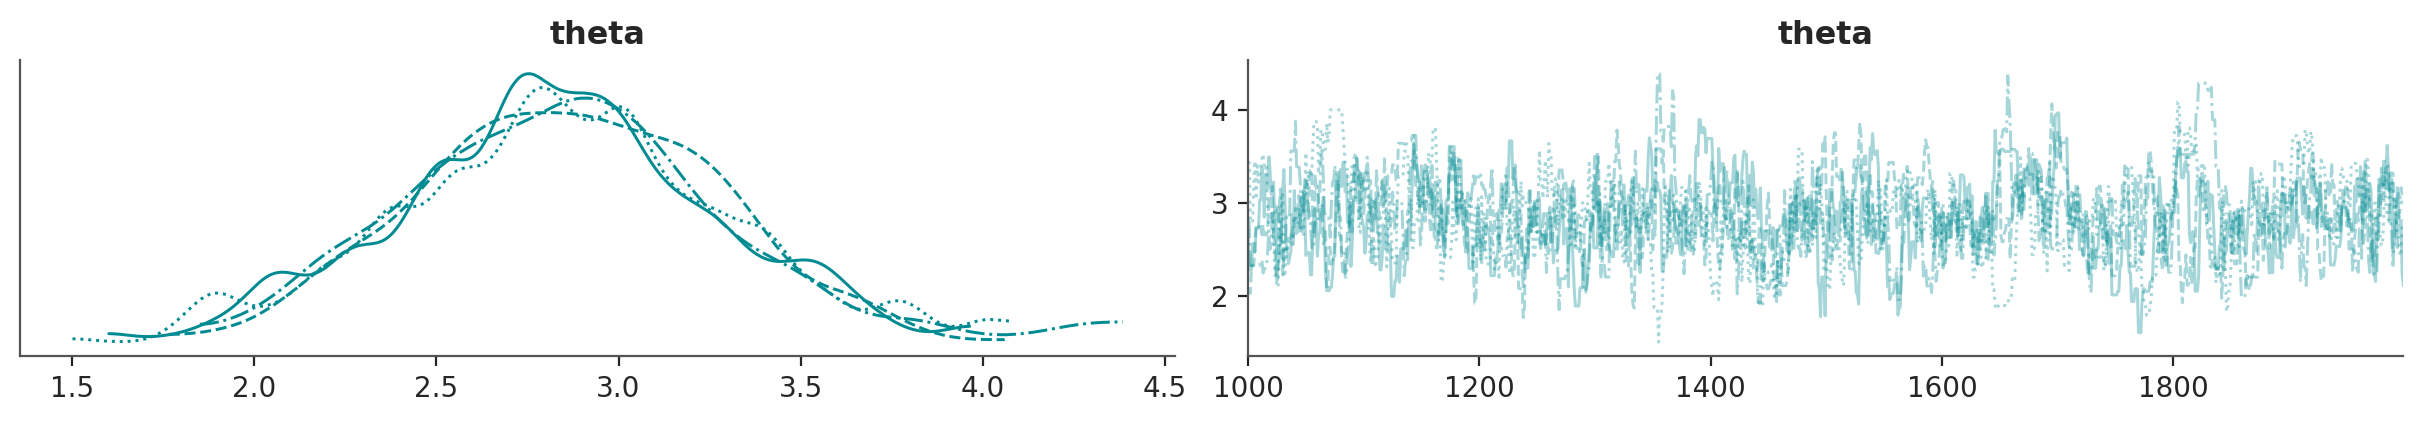

In [7]:
az.plot_trace(posterior_abc_sf)

<Axes: ylabel='Density'>

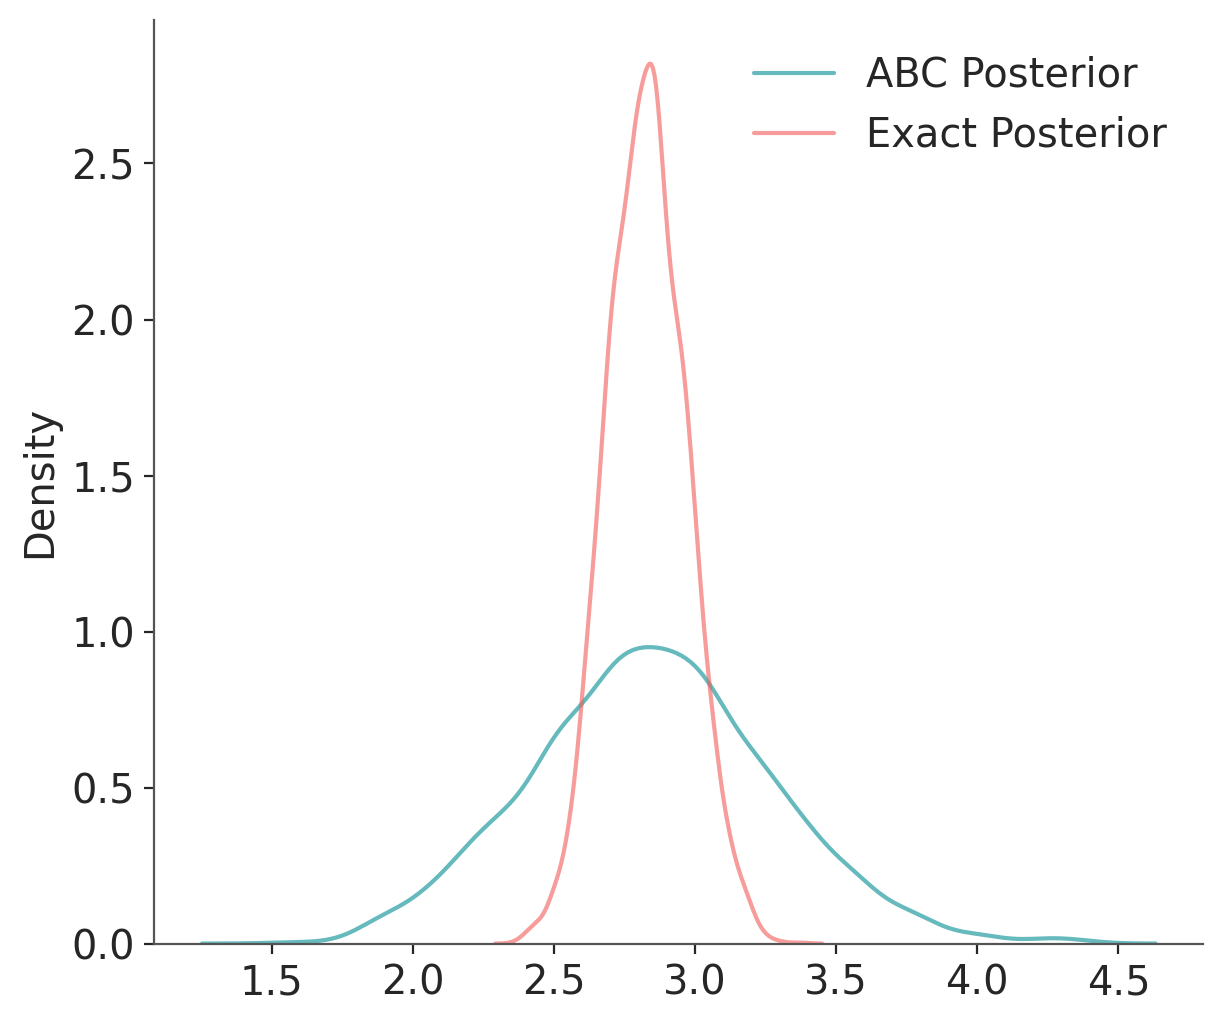

In [8]:
sns.kdeplot(
    posterior_abc_sf.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior",
)
# Ground truth posterior (conjugate normal)
posterior_exact = dist.Normal(observed_y.mean(), 1 / jnp.sqrt(50)).sample(
    jr.key(1), (5000,)
)
posterior_exact = posterior_exact[
    (posterior_exact >= -5) & (posterior_exact <= 5)
]  # Truncate to match uniform prior support
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()

Often, sufficient summary statistics are not available. One popular distance metric between the observed and simulated data is the Wasserstein distance:

In [9]:
# Wrap wasserstein_distance with pure_callback for JAX compatibility
def wasserstein_distance(a, b):
    from scipy.stats import wasserstein_distance as swd

    def _compute(a, b):
        a_np = np.asarray(a)
        b_np = np.asarray(b)
        if a_np.ndim == 1:
            return swd(a_np, b_np)
        else:
            return np.array([swd(x, b_np) for x in a_np])

    if a.ndim == 1:
        out_shape = jax.ShapeDtypeStruct((), jnp.float32)
    else:
        out_shape = jax.ShapeDtypeStruct((a.shape[0],), jnp.float32)

    return jax.pure_callback(_compute, out_shape, a, b, vmap_method="sequential")

In [10]:
init_pos_ws = [
    {"theta": jnp.array([-4.0])},
    {"theta": jnp.array([-1.0])},
    {"theta": jnp.array([1.0])},
    {"theta": jnp.array([4.0])},
]
posterior_abc_ws = abc_mcmc(
    key=jr.key(42),
    log_prior_density=log_prior_density,
    proposal_covariance=jnp.array([[0.1]]),
    initial_positions=init_pos_ws,
    simulator=simulator,
    num_samples=2000,
    s_obs=observed_y,  # Use raw observed data (no summary stat)
    distance=wasserstein_distance,
    kernel=gaussian_kernel,
    h=0.5,
)
posterior_abc_ws = posterior_abc_ws.isel(draw=(slice(1_000, None)))

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

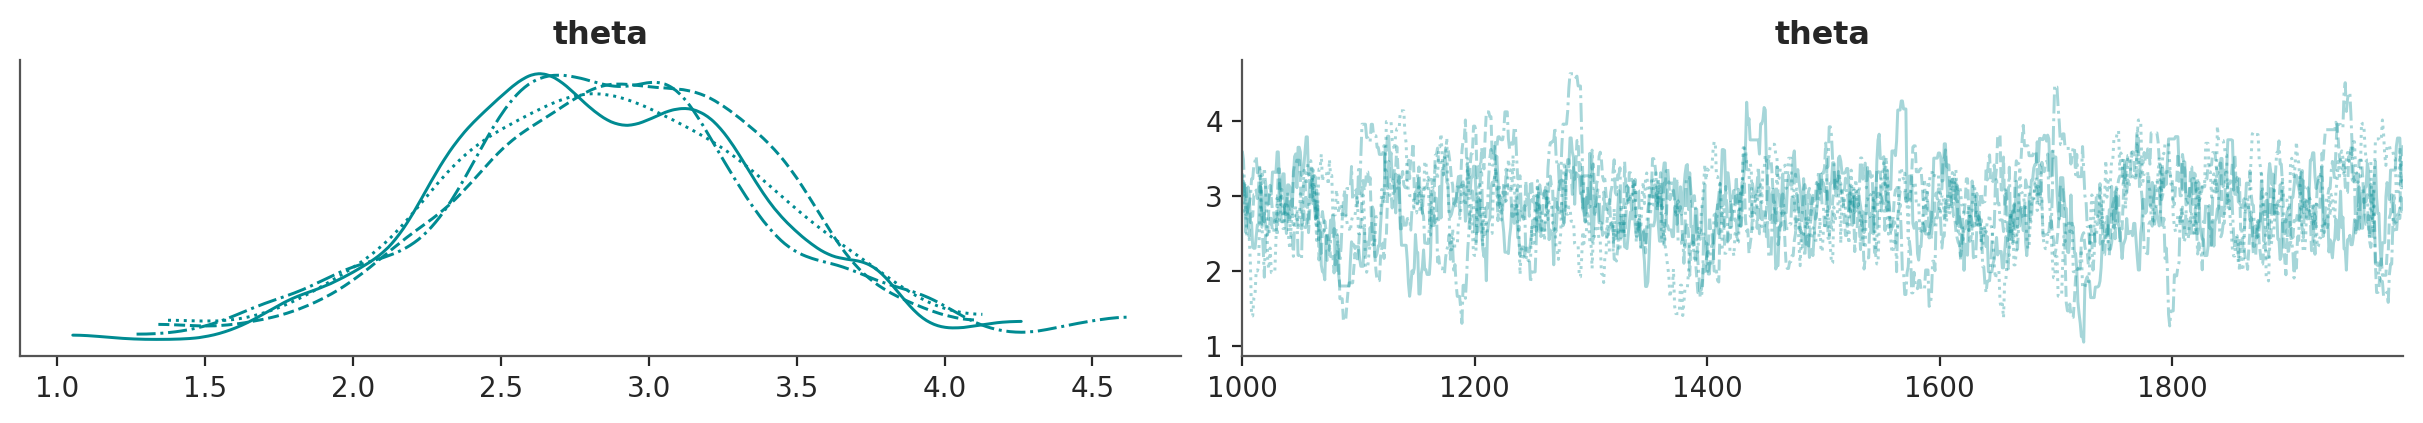

In [11]:
az.plot_trace(posterior_abc_ws)

<Axes: ylabel='Density'>

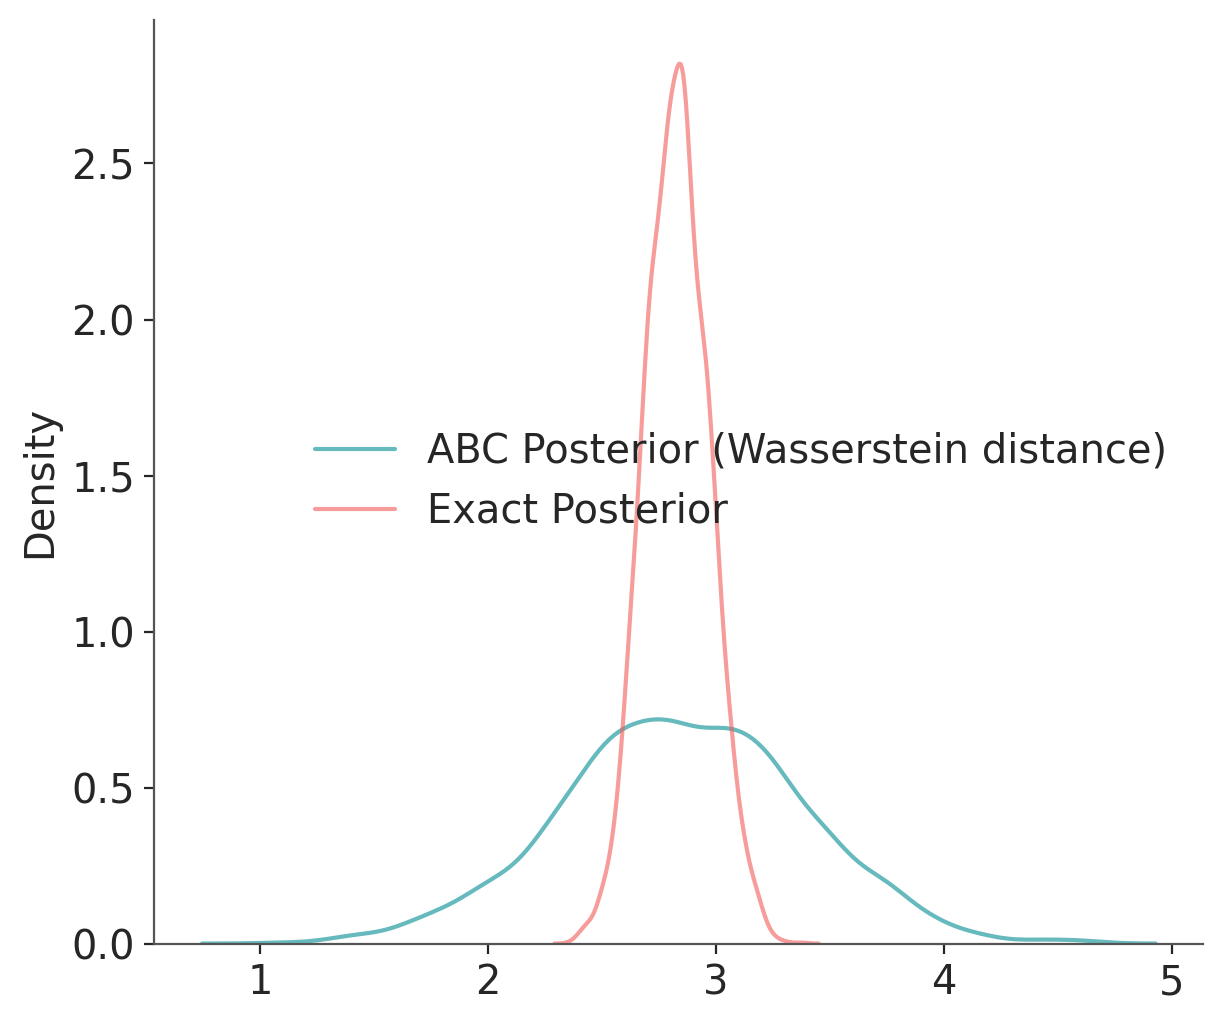

In [12]:
sns.kdeplot(
    posterior_abc_ws.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="ABC Posterior (Wasserstein distance)",
)
# Ground truth posterior (conjugate normal)
sns.kdeplot(posterior_exact, alpha=0.6, color="C1", label="Exact Posterior")
plt.legend()
plt.gca()